In [3]:
#initializing torch cuda device_encoding
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
import torch
import torchtext

print("Torch Text Version : {}".format(torchtext.__version__))

Torch Text Version : 0.11.2


In [5]:
import nltk
# nltk.download('brown')
# nltk.download('punkt')
from nltk.corpus import brown


In [6]:
#Getting the tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [7]:
from collections import Counter
import itertools
import re

#function to create corpus list
def create_clean(sentence):
    clean = []
    for word in sentence:
        #lowercase
        word = word.lower()
        #removed punctuation
        word = word.strip('\'"?,.')
        #removed any non-alphanumeric characters
        word = re.sub(r'[^a-zA-Z0-9]', '', word)
        #replaced URL with the word URL
        word = word.replace('http\://', 'URL')
        #removed HTML tags
        word = word.replace('<br />', ' ')
        #if there is nothing left, skip the word
        if not word:
            continue
        clean.append(word)
    return clean

def create_corpus(text):
    corpu = []
    corpus = []
    for sentence in text:
        corpu.extend(sentence)
    corpus = ' '.join(corpu)
    return corpus, corpu

#calling functions
corpus, corpu = create_corpus(brown.sents())
corpus_tokens = tokenizer(corpus.lower())
corpus = ' '.join(corpus_tokens)

#create vocab list based on corpus
def create_vocab(corpus):
    vocab = {}
    #tokenize the corpus based on spaces
    for i, word in enumerate(corpus):
        #if dictionary doesn't have the word, add it to the dictionary and assign it an index
        if word not in vocab:
            vocab[word] = i
        else:
            continue
    return vocab

#calling fucntion to initialize the vocab list
vocab = create_vocab(list(set(corpus_tokens)))
vocab['UNK'] = len(vocab)

In [8]:
#Building the dataset suitably using pytorch Dataset and DataLoaders
from torch.utils.data import Dataset, DataLoader
class LMData(Dataset):
    def __init__(self, corpus, vocab, seq_len):
        self.corpus = corpus
        self.vocab = vocab
        self.seq_len = seq_len
#         self.corpus_list = corpus.split()
        self.corpus_list = corpus_tokens
        self.corpus_idx = [self.vocab[w] for w in self.corpus_list]
        self.input_data = self.corpus_idx[:-1] #It slices the string to omit the last character, in this case a newline character:
        self.target_data = self.corpus_idx[1:] #1 onwards, leaves last ticket
        self.inputs = [self.input_data[i:i+self.seq_len] for i in range(0,len(self.input_data)-self.seq_len)]
        self.targeter = [self.target_data[i:i+self.seq_len] for i in range(0,len(self.input_data)-self.seq_len)]
        self.targets = [target[-1] for target in self.targeter]
    def __getitem__(self, index):
        input_idx = torch.tensor(self.inputs[index]).to(device)
        target_idx = torch.tensor(self.targets[index]).to(device)
        return (input_idx, target_idx)
    def __len__(self):
        return len(self.inputs)

#Calling the class to create the dataset
total_dataset = LMData(corpus, vocab, seq_len = 4)

# #Printing dimensions and sample for self verification
# total_dataset[5]
# print(total_dataset.corpus_list[:10])
# #print corpus idx
# print(total_dataset.corpus_idx[:10]) 
# #orint length of the dataset
# len(total_dataset)
# print(total_dataset.inputs[:10])
# print(total_dataset.targets[:10])
# print(len(total_dataset.inputs))
# print(len(total_dataset.targets))

In [9]:
#Splitting the dataset into Train, Val and Test according to 0.7, 0.1, 0.2 split
from torch.utils.data import Subset
def create_train_val_test(dataset, split_val, split_test):
    split_1 = int(len(dataset)*(1-split_val-split_test))
    split_2 = int(len(dataset)*(1-split_test))
    return Subset(dataset, range(split_1)), Subset(dataset, range(split_1, split_2)), Subset(dataset, range(split_2, len(dataset)))
train_set, val_set, test_set = create_train_val_test(total_dataset, split_val = 0.1, split_test = 0.2)
# print(len(train_set), len(val_set), len(test_set))

In [56]:
#Using Dataloaders to generate the dataset into suitable batch sizes and shuffling them up
from torch.utils.data import DataLoader
batch_size = 64
trn_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
x_train,y_train = next(iter(trn_loader))
print("Train Data Loader shape:")
print(x_train.shape, y_train.shape)

val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
x_val,y_val = next(iter(val_loader))
print("Val Data Loader shape:")
print(x_val.shape, y_val.shape)

test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)
x_test,y_test = next(iter(test_loader))
print("Test Data Loader shape:")
print(x_test.shape, y_test.shape)


Train Data Loader shape:
torch.Size([64, 4]) torch.Size([64])
Val Data Loader shape:
torch.Size([64, 4]) torch.Size([64])
Test Data Loader shape:
torch.Size([64, 4]) torch.Size([64])


In [57]:
#Getting GloVe word embeddings
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=100)

In [58]:
# Testing the execution of the downloaded word embeddings
# print(global_vectors.get_vecs_by_tokens(['hi'], lower_case_backup=True))

In [59]:
#Creating and embedding matrix 
#Will be used later on when creating the language model 
from pickletools import optimize
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def create_embedding_matrix(vocab, embedding_dim):
    counte = 0
    # embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    embedding_matrix = torch.randn(len(vocab), embedding_dim)
    for word, index in vocab.items():
        try:
            # embedding_vector = embed_model[word]
            embedding_vector = global_vectors.get_vecs_by_tokens([word], lower_case_backup=True)
            if embedding_vector is not None:
                counte += 1
                # embedding_matrix[index] = torch.from_numpy(embedding_vector)
                embedding_matrix[index] = embedding_vector
        except KeyError:
            pass
    return embedding_matrix.detach().clone()

embedding_matrix = create_embedding_matrix(vocab, embedding_dim = 100)

In [60]:
# #print shape of embedding matrix
# print(embedding_matrix.shape)
# #print few examples of the embedding matrix
# print(embedding_matrix[:10])

# Model 1


In [61]:
#Class to create Language Model 1 based on document specifications
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__() #nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.hidden_layer1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, input_seq):
        #taking embeddings, moving to hidden layer 1 to hidden layer 2 to output layer
        embeddings = self.embedding(input_seq)
        embeddings = embeddings.view(-1, 4*100)
        hidden_layer1_output = torch.tanh(self.hidden_layer1(embeddings))
        hidden_layer2_output = F.relu(self.hidden_layer2(hidden_layer1_output))
        output = self.output_layer(hidden_layer2_output)
        return output

model = LanguageModel(vocab_size = len(vocab), embedding_dim = 400, hidden_dim = 300)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [62]:
#storing the values in a dictionary to plot them later on
epo = 15
m1_losses = {'train':[], 'val':[], 'epoch':[]}
for epoch in range(epo+1):
    loss = 0
    model.train()
    for i, (input_seq, target_seq) in enumerate(trn_loader):
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        optimizer.zero_grad()
        output_seq = model(input_seq)
        loss = criterion(output_seq, target_seq)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Epoch: {}/{}'.format(epoch, epo), 'Step: {}/{}'.format(i, len(trn_loader)), 'Train Loss: {}'.format(loss.item()))
    valid_loss = 0.0
    model.eval()
    for i, (input_seq, target_seq) in enumerate(val_loader):
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        output_seq = model(input_seq)
        valid_loss = criterion(output_seq, target_seq)
        if i % 1000 == 0:
            print('Epoch: {}/{}'.format(epoch, epo), 'Step: {}/{}'.format(i, len(val_loader)), 'Val Loss: {}'.format(valid_loss.item()))
    #print the loss after each epoch
    print('Epoch: {}/{}'.format(epoch, epo), 'Train Loss: {}'.format(loss.item()), 'Valid Loss: {}'.format(valid_loss.item()))
    m1_losses['train'].append(loss.item())
    m1_losses['val'].append(valid_loss.item())
    m1_losses['epoch'].append(epoch)
    #save the model after training
torch.save(model.state_dict(), 'model.pt')

Epoch: 0/15 Step: 0/13042 Train Loss: 10.774659156799316
Epoch: 0/15 Step: 1000/13042 Train Loss: 6.4694318771362305
Epoch: 0/15 Step: 2000/13042 Train Loss: 6.0938639640808105
Epoch: 0/15 Step: 3000/13042 Train Loss: 6.0068488121032715
Epoch: 0/15 Step: 4000/13042 Train Loss: 5.883129596710205
Epoch: 0/15 Step: 5000/13042 Train Loss: 6.6871018409729
Epoch: 0/15 Step: 6000/13042 Train Loss: 6.0791335105896
Epoch: 0/15 Step: 7000/13042 Train Loss: 6.059063911437988
Epoch: 0/15 Step: 8000/13042 Train Loss: 6.765974998474121
Epoch: 0/15 Step: 9000/13042 Train Loss: 6.443014144897461
Epoch: 0/15 Step: 10000/13042 Train Loss: 6.973055839538574
Epoch: 0/15 Step: 11000/13042 Train Loss: 6.320432186126709
Epoch: 0/15 Step: 12000/13042 Train Loss: 6.2841033935546875
Epoch: 0/15 Step: 13000/13042 Train Loss: 6.193992614746094
Epoch: 0/15 Step: 0/1864 Val Loss: 6.079044818878174
Epoch: 0/15 Step: 1000/1864 Val Loss: 5.789690971374512
Epoch: 0/15 Train Loss: 7.22944974899292 Valid Loss: 9.61831092

Epoch: 8/15 Step: 3000/13042 Train Loss: 5.449151039123535
Epoch: 8/15 Step: 4000/13042 Train Loss: 6.362090110778809
Epoch: 8/15 Step: 5000/13042 Train Loss: 6.893881797790527
Epoch: 8/15 Step: 6000/13042 Train Loss: 5.6170759201049805
Epoch: 8/15 Step: 7000/13042 Train Loss: 5.904247283935547
Epoch: 8/15 Step: 8000/13042 Train Loss: 6.523853302001953
Epoch: 8/15 Step: 9000/13042 Train Loss: 6.361687660217285
Epoch: 8/15 Step: 10000/13042 Train Loss: 6.832927227020264
Epoch: 8/15 Step: 11000/13042 Train Loss: 6.276283264160156
Epoch: 8/15 Step: 12000/13042 Train Loss: 7.693920135498047
Epoch: 8/15 Step: 13000/13042 Train Loss: 6.379642486572266
Epoch: 8/15 Step: 0/1864 Val Loss: 6.629348278045654
Epoch: 8/15 Step: 1000/1864 Val Loss: 8.588554382324219
Epoch: 8/15 Train Loss: 6.126292705535889 Valid Loss: 10.961559295654297
Epoch: 9/15 Step: 0/13042 Train Loss: 5.89928674697876
Epoch: 9/15 Step: 1000/13042 Train Loss: 7.264386177062988
Epoch: 9/15 Step: 2000/13042 Train Loss: 5.6850571

In [63]:
#print dictionary of train, validation loss
print(m1_losses)

{'train': [7.22944974899292, 6.633575439453125, 7.531216144561768, 5.501524448394775, 5.7366414070129395, 8.011346817016602, 5.472721576690674, 4.868537425994873, 6.126292705535889, 7.029165744781494, 6.544813632965088, 5.707226276397705, 6.645009994506836, 9.088444709777832, 5.8217949867248535, 6.480264186859131], 'val': [9.618310928344727, 4.105562210083008, 5.978867053985596, 5.171982765197754, 7.051451683044434, 10.407276153564453, 4.658061981201172, 7.144930362701416, 10.961559295654297, 3.7719836235046387, 4.6234636306762695, 5.1165452003479, 6.487529277801514, 7.258777618408203, 4.390444278717041, 14.361724853515625], 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}


<IPython.core.display.Javascript object>


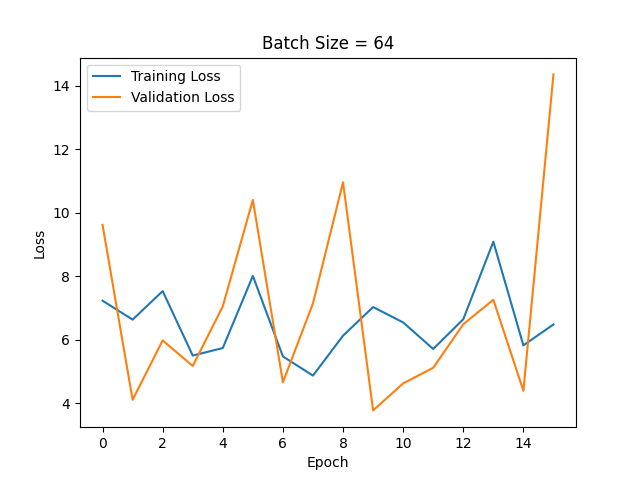

In [64]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.plot(m1_losses['epoch'], m1_losses['train'], label = 'Training Loss')
plt.plot(m1_losses['epoch'], m1_losses['val'], label = 'Validation Loss')
plt.title('LM 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('LM 1.png')

In [81]:
# test_sentences = brown.sents()[:25000]#print a few examples of the test sentences
test_sentences = brown.sents()[:25000] #taking last few test sentences

In [82]:
test_sentences = [sentence for sentence in test_sentences if len(sentence) > 6]
cleaned_test_sentences = []
for i in test_sentences:   
    #use function create_clean to clean the sentences 
    temp = ' '.join(i)
    cleaned_test_sentences.append(tokenizer(temp))

In [83]:
rnn = model
rnn.eval()
perplexities = []
final_sent = []
for i in cleaned_test_sentences:
    #create 4-grams from the sentence and store it in a list
    try:
        input_seq = [i[j:j+4] for j in range(len(i)-4)]
        target_seq = i[len(i)-len(input_seq):]
        new_input_seq = []
        for seq in input_seq:
            seqe = []
            for word in seq:
                seqe.append(vocab[word])
            new_input_seq.append(seqe)
        target_seq = [vocab[word] for word in target_seq]
        input_seq = torch.LongTensor(new_input_seq).to(device)
        target_seq = torch.LongTensor(target_seq).to(device)
        output = rnn(input_seq)
        loss = criterion(output, target_seq)
        perplexity = torch.exp(loss)
        perplexity = perplexity.cpu().detach().numpy()
        perplexities.append(perplexity)
        final_sent.append(' '.join(i))
    except:
        pass

In [79]:
import numpy as np
perplex = []
# #Perplexities for train 
# with open('2020114017-LM1-train-perplexity.txt', 'w') as f:
#     for i in range(len(perplexities)):
#         if perplexities[i] <= len(vocab):
#             perplex.append(perplexities[i])
#             f.write(final_sent[i] + '\t' + str(perplexities[i]) + '\n')
#     f.write('Average perplexity score: ' + str(np.mean(perplex)))
    
#Perplexities for test
with open('64m12.txt', 'w') as f:
    for i in range(len(perplexities)):
        if perplexities[i] <= len(vocab):
            perplex.append(perplexities[i])
            f.write(final_sent[i] + '\t' + str(perplexities[i]) + '\n')
    f.write('Average perplexity score: ' + str(np.mean(perplex)))